In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os
from utils import ELEMENTS_NAMES, ELEMENTS_UNITS
from tqdm.notebook import tqdm
from itertools import product
from concurrent.futures import ProcessPoolExecutor, as_completed
from collections import defaultdict
import pandas as pd

figures_dir = "../figures/base_accuracy"
colors = {
    "era5": "b",
    "noaa": "r",
    "globsnow": "r"
}
years = list(range(1991, 2020))

os.makedirs(figures_dir, exist_ok=True)

In [2]:
def process_week_pair(year, week):
    try:
        ds1 = xr.open_dataset(f"../data/merge/inmcm_swe/{year}{week:02d}.nc", engine="h5netcdf")
        ds2 = xr.open_dataset(f"../data/merge/era5_swe/{year}{week:02d}.nc", engine="h5netcdf").interp(lat=lat, lon=lon)
        ds3 = xr.open_dataset(f"../data/merge/globsnow/{year}{week:02d}.nc", engine="h5netcdf").interp(lat=lat, lon=lon)
        inmcm_climate = climate[f"swe_{week:02d}"]
        v1 = ds1.swe.values + inmcm_climate
        v2 = ds2.swe.values + climate[f"era5_swe_{week:02d}"]
        v3 = ds3.swe.values + climate[f"globsnow_{week:02d}"]
        mask = (np.isnan(inmcm_climate)) | (inmcm_climate <= 0)
        v2[mask] = np.nan
        v3[mask] = np.nan
        d1, d2 = v1 - v2, v1 - v3
        return {"era5": d1, "globsnow": d2}, ds1.lead_time.values
    except Exception as e:
        return {}, []

ds = xr.open_dataset(f"../data/merge/inmcm_swe/199104.nc", engine="h5netcdf")
lat, lon = ds.lat.values, ds.lon.values
pairs = list(product(years, range(1, 53)))
datasets = []

climate = {}

for week in range(1, 53):
    for element in ["swe", "era5_swe", "globsnow"]:
        try:
            ds = xr.open_dataset(f"../data/climate/week/{element}/{week:02d}.nc", engine="h5netcdf").interp(lat=lat, lon=lon)
            climate[f"{element}_{week:02d}"] = ds.swe.values
        except:
            continue

errors = []
means = {}
counts = {}
for year, week in tqdm(pairs):
    d, lead_times = process_week_pair(year, week)
    for i, lead_time in enumerate(lead_times):
        for source in d:
            idx = f"{source}_{lead_time}"
            v = d[source][i, :, :]
            if not source in counts:
                means[source] = np.zeros_like(v, dtype=np.float32)
                counts[source] = np.zeros_like(v, dtype=np.int32)
            mask = ~np.isnan(v)
            means[source][mask] += v[mask]
            counts[source][mask] += 1
            errors.append((source, lead_time, year, week, np.nanmedian(np.abs(v))))
for key in counts:
    means[key][counts[key] > 0] /= counts[key][counts[key] > 0]
df = pd.DataFrame(errors, columns=["source", "lead_time", "year", "week", "value"])
df["date"] = pd.to_datetime(df["year"].astype(str) + df["week"].astype(str) + '1',
                            format="%Y%W%w")
df = df.drop(columns=["year"])

  0%|          | 0/1508 [00:00<?, ?it/s]

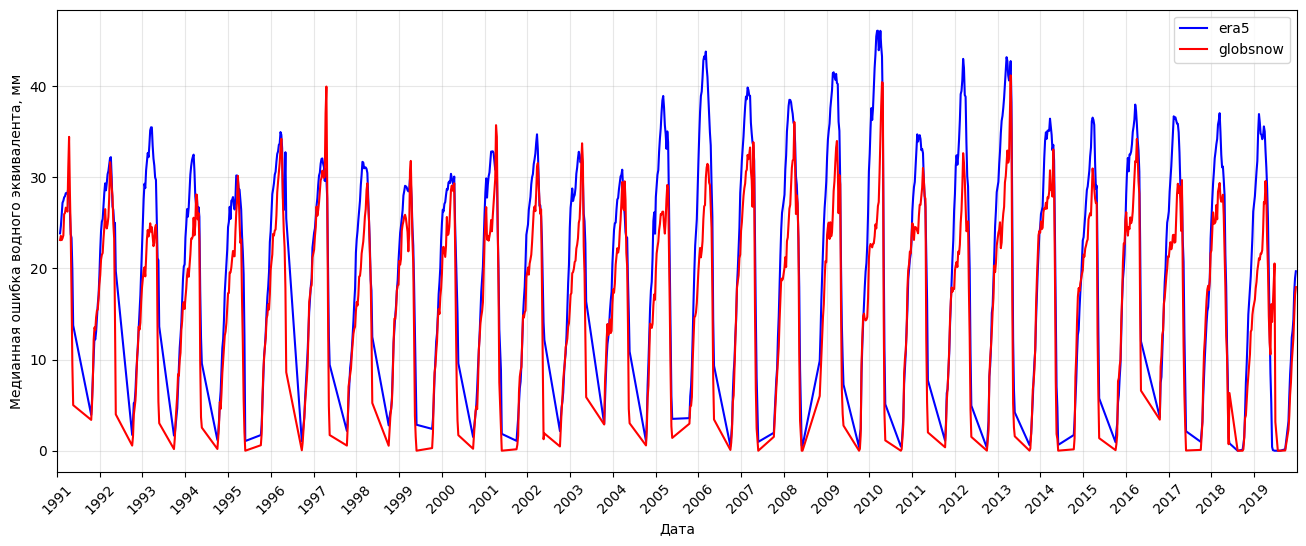

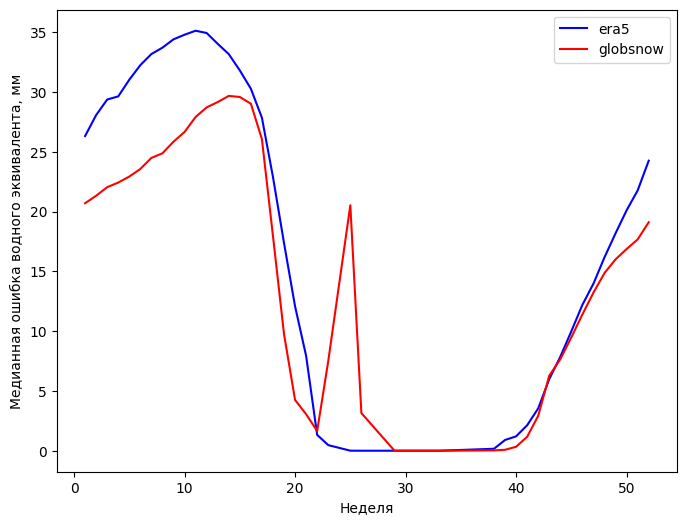

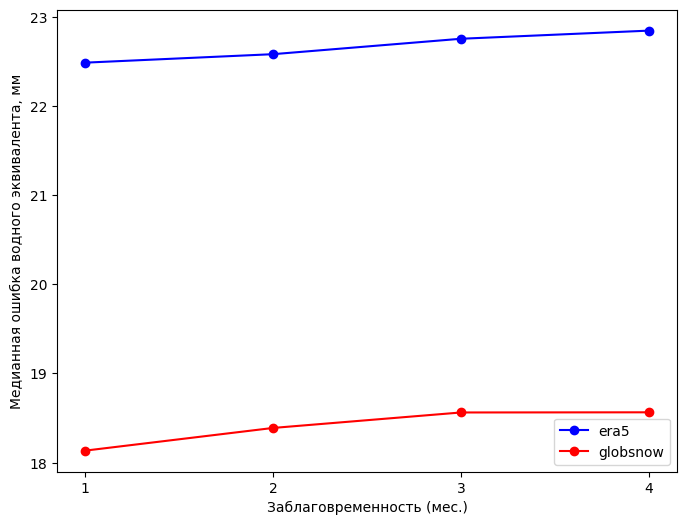

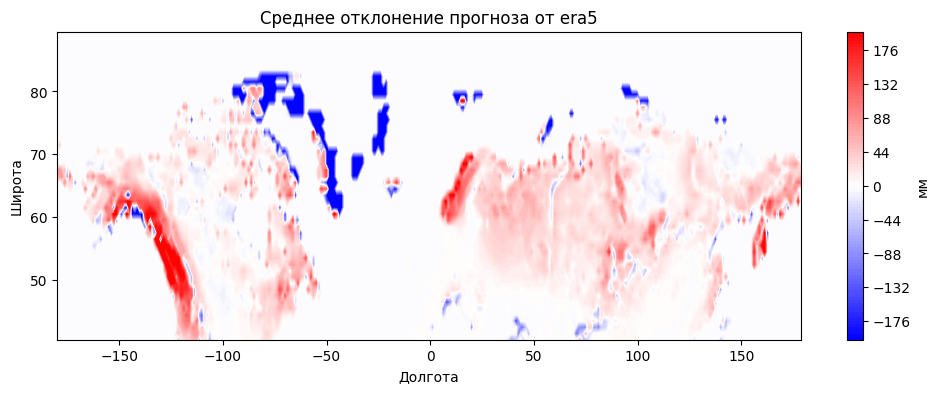

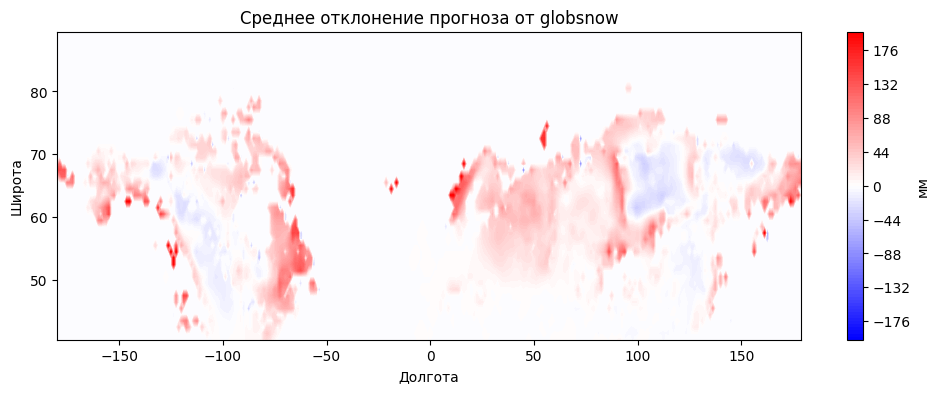

In [3]:
plt.figure(figsize=(16, 6))
sources = ["era5", "globsnow"]
for source in sources:
    df_source = df[(df["source"] == source) & (df["lead_time"] == 0)]
    plt.plot(df_source["date"], df_source["value"], color=colors[source])
plt.legend(sources)
plt.xlabel("Дата")
plt.ylabel("Медианная ошибка водного эквивалента, мм")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.xticks([pd.Timestamp(year, 1, 1) for year in years], years)
plt.xlim([pd.Timestamp(1991, 1, 1), pd.Timestamp(2020, 1, 1)])
plt.savefig(f'{figures_dir}/swe_by_year.png', dpi=150, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 6))
for source in sources:
    df_source = df[(df["source"] == source) & (df["lead_time"] == 0)].groupby("week")[["value"]].mean()
    plt.plot(df_source.index, df_source["value"], color=colors[source])
plt.legend(sources)
plt.xlabel("Неделя")
plt.ylabel("Медианная ошибка водного эквивалента, мм")
plt.savefig(f'{figures_dir}/swe_by_week.png', dpi=150, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 6))
for source in sources:
    df_source = df[(df["source"] == source) & (df["lead_time"] < 4)].groupby("lead_time")[["value"]].mean()
    plt.plot(df_source.index + 1, df_source["value"], marker="o", color=colors[source])
plt.legend(sources)
plt.xlabel("Заблаговременность (мес.)")
plt.xticks(np.arange(1, 5))
plt.ylabel("Медианная ошибка водного эквивалента, мм")
plt.savefig(f'{figures_dir}/swe_by_lead_time.png', dpi=150, bbox_inches='tight')
plt.show()

for key in sorted(means.keys()):
    plt.figure(figsize=(12, 4))
    plt.contourf(lon, lat, np.minimum(200, np.maximum(-200, means[key])), np.linspace(-200, 200, 101), cmap="bwr")
    plt.xlabel("Долгота")
    plt.ylabel("Широта")
    plt.title(f"Среднее отклонение прогноза от {key}")
    cb = plt.colorbar()
    cb.set_label("мм")
    plt.savefig(f'{figures_dir}/swe_err_{key}.png', dpi=150, bbox_inches='tight')
    plt.show()

In [4]:
def process_month_pair(year, month):
    try:
        ds1 = xr.open_dataset(f"../data/merge/inmcm_ice/{year}{month:02d}.nc", engine="h5netcdf")
        ds2 = xr.open_dataset(f"../data/merge/era5_ice/{year}{month:02d}.nc", engine="h5netcdf").interp(lat=lat, lon=lon)
        ds3 = xr.open_dataset(f"../data/merge/noaa_ice/{year}{month:02d}.nc", engine="h5netcdf").interp(lat=lat, lon=lon)
        v1 = ds1.aice.values + climate[f"aice_{month:02d}"]
        v2 = ds2.ice.values + climate[f"era5_ice_{month:02d}"]
        v3 = ds3.ice.values + climate[f"noaa_ice_{month:02d}"]
        d1, d2 = v1 - v2, v1 - v3
        return {"era5": d1, "noaa": d2}, ds1.lead_time.values
    except Exception as e:
        return {}, []

ds = xr.open_dataset(f"../data/merge/inmcm_ice/199104.nc", engine="h5netcdf")
lat, lon = ds.lat.values, ds.lon.values
pairs = list(product(years, range(1, 13)))
datasets = []

climate = {}

for month in range(1, 13):
    for element in ["aice", "era5_ice", "noaa_ice"]:
        try:
            element_var = "aice" if element == 'aice' else 'ice'
            ds = xr.open_dataset(f"../data/climate/month/{element}/{month:02d}.nc", engine="h5netcdf").interp(lat=lat, lon=lon)
            climate[f"{element}_{month:02d}"] = ds[element_var].values
        except:
            continue

errors = []
means = {}
counts = defaultdict(int)
for year, month in tqdm(pairs):
    d, lead_times = process_month_pair(year, month)
    for i, lead_time in enumerate(lead_times):
        for source in d:
            v = d[source][i, :, :]
            if not source in counts:
                means[source] = np.zeros_like(v, dtype=np.float32)
                counts[source] = np.zeros_like(v, dtype=np.int32)
            mask = ~np.isnan(v)
            means[source][mask] += v[mask]
            counts[source][mask] += 1
            v[climate[f"aice_{month:02d}"] <= 0] = np.nan
            errors.append((source, lead_time, year, month, np.nanmean(np.abs(v))))
for key in counts:
    means[key][counts[key] > 0] /= counts[key][counts[key] > 0]
df = pd.DataFrame(errors, columns=["source", "lead_time", "year", "month", "value"])
df["date"] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))
df = df.drop(columns=["year"])

  0%|          | 0/348 [00:00<?, ?it/s]

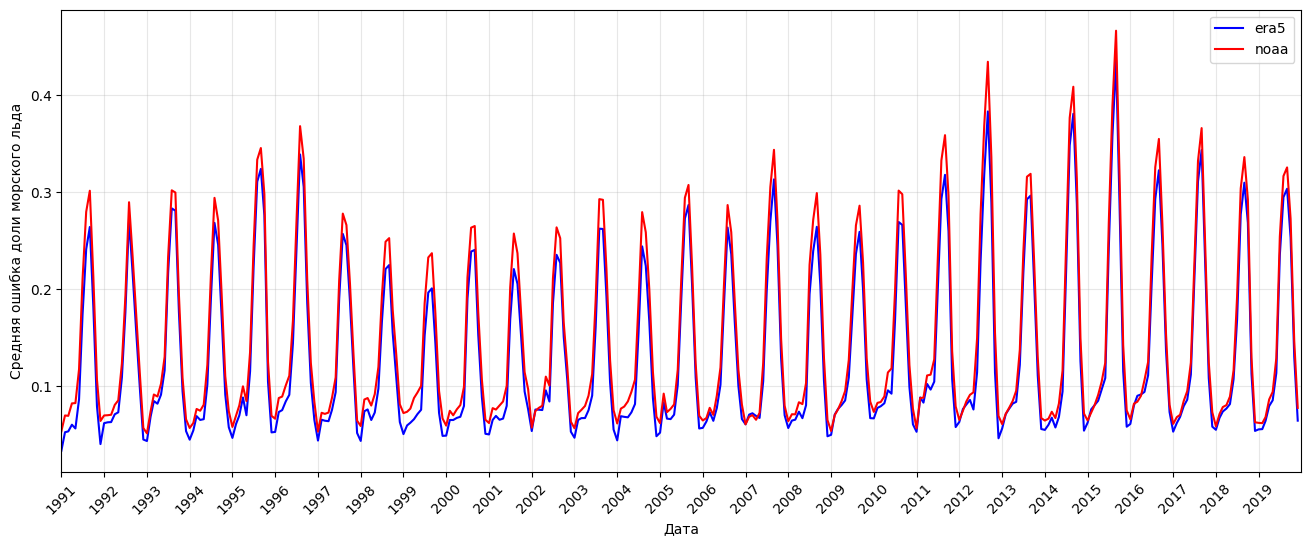

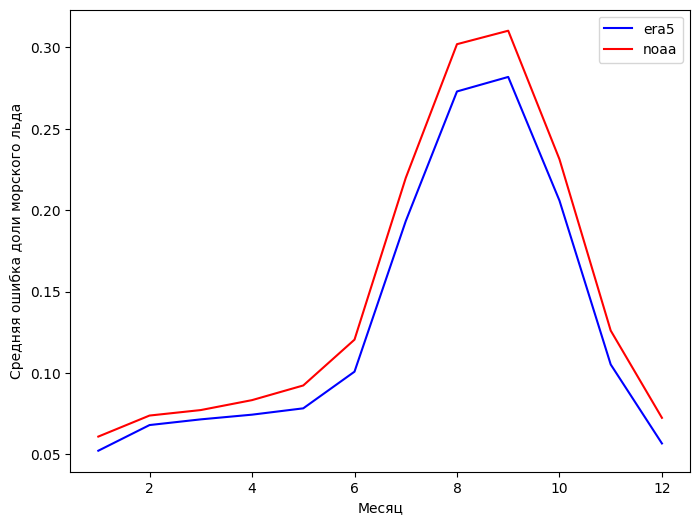

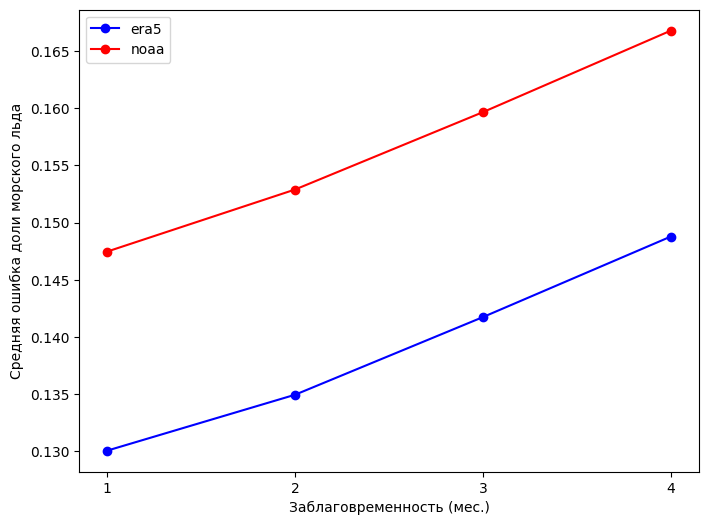

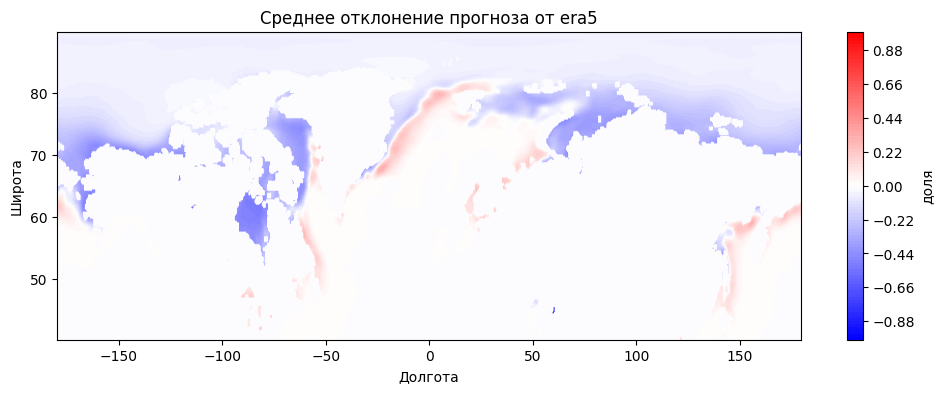

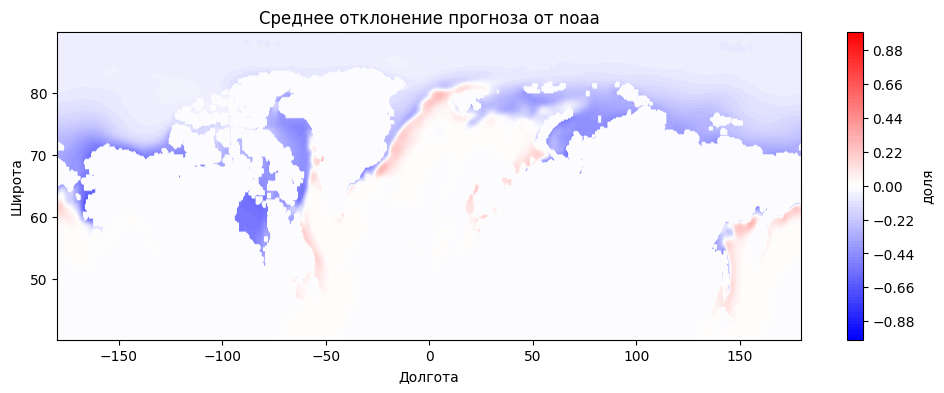

In [5]:
plt.figure(figsize=(16, 6))
sources = ["era5", "noaa"]
for source in sources:
    df_source = df[(df["source"] == source) & (df["lead_time"] == 0)]
    plt.plot(df_source["date"], df_source["value"], color=colors[source])
plt.legend(sources)
plt.xlabel("Дата")
plt.ylabel("Средняя ошибка доли морского льда")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.xticks([pd.Timestamp(year, 1, 1) for year in years], years)
plt.xlim([pd.Timestamp(1991, 1, 1), pd.Timestamp(2020, 1, 1)])
plt.savefig(f'{figures_dir}/ice_by_year.png', dpi=150, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 6))
for source in sources:
    df_source = df[(df["source"] == source) & (df["lead_time"] == 0)].groupby("month")[["value"]].mean()
    plt.plot(df_source.index, df_source["value"], color=colors[source])
plt.legend(sources)
plt.xlabel("Месяц")
plt.ylabel("Средняя ошибка доли морского льда")
plt.savefig(f'{figures_dir}/ice_by_month.png', dpi=150, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 6))
for source in sources:
    df_source = df[(df["source"] == source)].groupby("lead_time")[["value"]].mean()
    plt.plot(df_source.index + 1, df_source["value"], marker="o", color=colors[source])
plt.legend(sources)
plt.xlabel("Заблаговременность (мес.)")
plt.ylabel("Средняя ошибка доли морского льда")
plt.xticks(np.arange(1, 5))
plt.savefig(f'{figures_dir}/ice_by_lead_time.png', dpi=150, bbox_inches='tight')
plt.show()

for key in sorted(means.keys()):
    plt.figure(figsize=(12, 4))
    plt.contourf(lon, lat, means[key], np.linspace(-1, 1, 101), cmap="bwr")
    plt.xlabel("Долгота")
    plt.ylabel("Широта")
    plt.title(f"Среднее отклонение прогноза от {key}")
    cb = plt.colorbar()
    cb.set_label("доля")
    plt.savefig(f'{figures_dir}/ice_err_{key}.png', dpi=150, bbox_inches='tight')
    plt.show()